<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Ресемплирование-данных" data-toc-modified-id="Ресемплирование-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinealRegression" data-toc-modified-id="LinealRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinealRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Заключение" data-toc-modified-id="Заключение-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Заключение</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Исходные данные загружены. Тип данных у признака 'datetime' был сменем с object на datetime64. Также по этому столбцу был установлен индекс. Пропусков в данных нет.

### Ресемплирование данных

Проведем ресемплирование данных по одному часу, перед этим также проверим, что даты и время расположены в хронологическом порядке.

In [6]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


In [7]:
data = data.resample('1H').sum()

## Анализ

Проведем анализ данных. Для этого построим по временному ряду графики тренд, сезонность и остаток декомпозиции. Определим, является ли ряд стационарным. 

In [8]:
decomposed = seasonal_decompose(data)

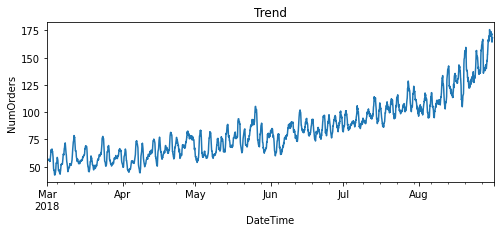

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');
plt.ylabel('NumOrders');
plt.xlabel('DateTime');

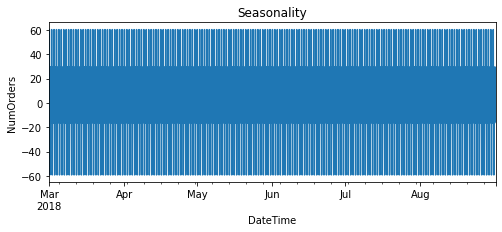

In [10]:
plt.figure(figsize=(8, 10))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality');
plt.ylabel('NumOrders');
plt.xlabel('DateTime');

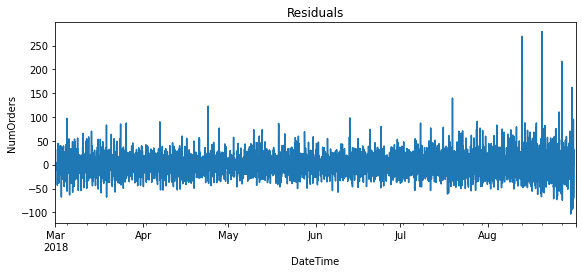

In [11]:
plt.figure(figsize=(8, 10))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.ylabel('NumOrders');
plt.xlabel('DateTime');

По графикам можно сделать вывод, что тренд прослеживается: идет постепенное увеличение заказов; сезонность также прослеживается.

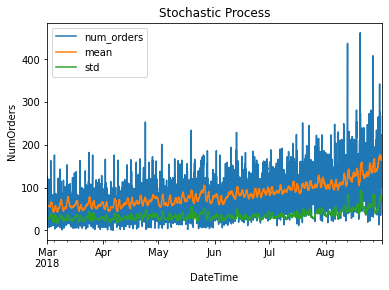

In [12]:
data_shift = data.copy()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot();
plt.ylabel('NumOrders');
plt.xlabel('DateTime');
plt.title('Stochastic Process');

Cреднее и стандартное отклонение меняются, а, значит, этот временной ряд является нестационнарным. Рассмотрим график разностей временного ряда.

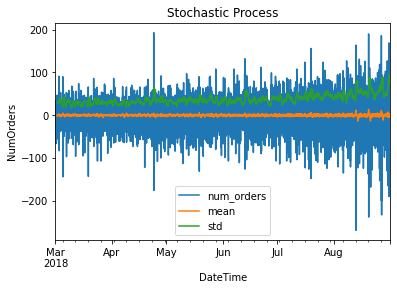

In [13]:
data_shift = data_shift - data_shift.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot();
plt.ylabel('NumOrders');
plt.xlabel('DateTime');
plt.title('Stochastic Process');

Разности временного ряда более стационарны, чем сам ряд

## Обучение

Разделим все данные на три выборки: тренировочкую, валидационную и тестовую. На первых двух выборках рассчитаем значение меткири RMSE, используя три модели: LinealRegression, RandomForestRegerssor, CatBoostRegressor. Модель с наилучшим показателем будет выбрана для работы с тестовой выборкой.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [15]:
make_features(data, 24, 48)

train, valitest = train_test_split(data, shuffle=False, train_size=0.75)
train = train.dropna()
valid, test = train_test_split(valitest, shuffle=False, test_size=0.4)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### LinealRegression

In [16]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 13.6 ms, sys: 6.64 ms, total: 20.2 ms
Wall time: 9.78 ms


LinearRegression()

In [17]:
%%time
predicted = model.predict(features_valid)
mse(predicted, target_valid) ** 0.5

CPU times: user 40.4 ms, sys: 46.9 ms, total: 87.3 ms
Wall time: 17.5 ms


33.47100888982541

### RandomForestRegressor

In [ ]:
%%time

best_rmse = 50
best_depth = None
best_n_estimators = None

for max_depth in range(10, 21, 2):
    for n_estimators in range(100, 201, 20):
        model = RandomForestRegressor(random_state=12345, 
                    max_depth=max_depth, n_estimators=n_estimators)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        result = mse(predicted, target_valid) ** 0.5
        if result < best_rmse:
            best_rmse = result
            best_depth = max_depth
            best_n_estimators = n_estimators
print(f'Наилучший показатель RMSE: {best_rmse}')
print(f'max_depth = {best_depth}')
print(f'n_estimators = {best_n_estimators}')

In [ ]:
%%time
model = RandomForestRegressor(random_state=12345, max_depth=14, n_estimators=200)
model.fit(features_train, target_train)

In [ ]:
%%time
predicted = model.predict(features_valid)
mse(predicted, target_valid) ** 0.5

### CatBoostRegressor

In [ ]:
%%time

best_rmse = 59
best_n_estimators = None

for n_estimators in range(100, 201, 20):
    model = CatBoostRegressor(learning_rate=0.5, random_state=12345, n_estimators=n_estimators, verbose=False)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    result = mse(predicted, target_valid) ** 0.5
    if result < best_rmse:
        best_rmse = result
        best_n_estimators = n_estimators

print(f'Наилучший показатель RMSE: {best_rmse}')
print(f'n_estimators = {best_n_estimators}')

In [ ]:
%%time
model = CatBoostRegressor(learning_rate=0.5,random_state=12345, n_estimators=100, verbose=False)
model.fit(features_train, target_train)

In [ ]:
%%time
predicted = model.predict(features_valid)
mse(predicted, target_valid) ** 0.5

Наилучший показатель метрики RMSE был у модели CatBoostRegressor. Эту модель используем для тестирования.

## Тестирование

In [ ]:
%%time
model = CatBoostRegressor(learning_rate=0.5, random_state=12345, n_estimators=100, verbose=False)
model.fit(features_train, target_train)
model.fit(features_valid, target_valid)
predicted = model.predict(features_test)
mse(predicted, target_test)**0.5

### Заключение

Необходимо было спрогнозировать количество заказов такси на следующий час. Для этого были проанализированы и ресеплированы входные данные.

Для обучения рассмотрены три модели: LinealRegression, RandomForestRegerssor, CatBoostRegressor. Качество обучения оценивалось на валидационной выборке по получившемуся значению метрики RMSE.

Наилучший показатель метрики RMSE был у модели CatBoostRegressor. Эта модел была рассмотрена для тестирования.

В результате показатель RMSE = 44.7969112358653 на модели CatBoostRegressor с показателями: learning_rate=0.5, n_estimators=100.